### **Importing the Libraries**

In [ ]:
import tensorflow as tf
import pandas as pd
import random
from imutils import paths
from tensorflow.keras.applications import VGG16, VGG19, Xception
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import cv2
import os
import seaborn as sns
import time
from keras.layers import Input, Lambda, Dense, Flatten,BatchNormalization,Dropout

**Google Drive Mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing Data**

Number of training images:  141
Number of training images:  141


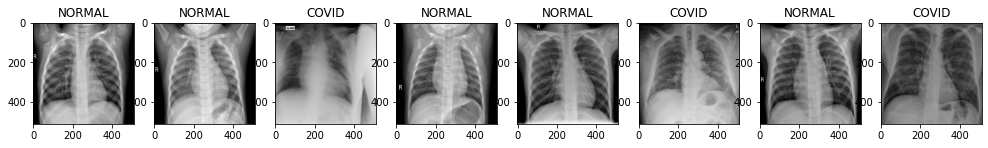

In [ ]:
path_ = list(paths.list_images('/content/drive/MyDrive/ml ass/dataset'))
X = []
Y = []
for path in path_:
    # Set Class label
    y = path.split(os.path.sep)[-2]
    #print(y)
    # Grayscale the image and reshape
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    # update the data and labels lists, respectively
    X.append(image)
    Y.append(y)

# Normalize images
X = np.array(X) / 255.0
Y = np.array(Y)
print('Number of training images: ', len(X))
print('Number of training images: ', len(Y))
#print(Y)
# Plot example patient scan
W = 8
L = 1
fig, axes = plt.subplots(L, W, figsize = (17,17))
axes = axes.ravel() 
n = 138

for i in np.arange(0, W * L):
    index = np.random.randint(0, n)    
    axes[i].imshow( X[index] )
    axes[i].set_title(Y[index])

#one-hot encoding on the labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)
Y = tf.keras.utils.to_categorical(Y)

### **Splitting the data**

In [ ]:
# split training and test data

(X_train, x_test, Y_train, y_test) = train_test_split(X, Y,test_size=0.20)

(x_train, x_valid, y_train, y_valid) = train_test_split(X_train, Y_train,test_size=0.20)


### **Data Augmentation**

In [ ]:
Datagen= tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                            rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)

### **Different CNN Algorithm Structure**

**1. VGG16**

In [ ]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG16(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model



**Fitting the VGG16 model**

In [ ]:
model = Covid_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1,patience=10,mode='max',restore_best_weights=True)
covid= model.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8,validation_data=(x_valid, y_valid), epochs=5,callbacks = [early_stopping])

58892288/58889256 [==============================] - 0s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
12/11 [================================] - 7s 581ms/step - loss: 3.9223 - accuracy: 0.4944 - val_loss: 0.4978 - val_accuracy: 0.8696
Epoch 2/5
12/11 [================================] - 5s 417ms/step - loss: 1.0059 - accuracy: 0.5955 - val_loss: 0.3870 - val_accuracy: 0.8696
Epoch 3/5
12/11 [================================] - 5s 417ms/step - loss: 0.7575 - accuracy: 0.6292 - val_loss: 0.5376 - val_accuracy: 0.7391
Epoch 4/5
12/11 [================================] - 6s 463ms/step - loss: 0.4668 - accuracy: 0.8202 - val_loss: 0.2078 - val_accuracy: 0.9565
Epoch 5/5
12/11 [================================] - 5s 414ms/step - loss: 0.3572 - accuracy: 0.8427 - val_loss: 0.1982 - val_accuracy: 0.9565


### **Prediction and value calculation**

In [ ]:
tic=time.clock()
y_pred = model.predict(x_test, batch_size=8)
toc=time.clock()
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

predicted_metrics = model.evaluate(x_test, y_test, batch_size=8, verbose=0)

for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)

acc=predicted_metrics[1]
print(classification_report(y_pred, y_true,target_names=lb.classes_))

cm = confusion_matrix(y_pred, y_true)

sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
time1=toc-tic

loss :  0.10427040606737137
accuracy :  1.0
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        15
      NORMAL       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



###**2. VGG19**

In [ ]:
def Covid_model2():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG19(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model

##**Model fittting**

In [ ]:
model2 = Covid_model()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',verbose=1,patience=10,mode='max',restore_best_weights=True)
covid2= model2.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8,validation_data=(x_valid, y_valid), epochs=5,callbacks = [early_stopping])


80142336/80134624 [==============================] - 4s 0us/step


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
12/11 [================================] - 6s 465ms/step - loss: 1.6750 - accuracy: 0.5730 - val_loss: 1.1889 - val_accuracy: 0.4783
Epoch 2/5
12/11 [================================] - 5s 452ms/step - loss: 1.7623 - accuracy: 0.5506 - val_loss: 0.4052 - val_accuracy: 0.8261
Epoch 3/5
12/11 [================================] - 5s 435ms/step - loss: 0.8150 - accuracy: 0.6742 - val_loss: 0.3053 - val_accuracy: 0.9565
Epoch 4/5
12/11 [================================] - 5s 426ms/step - loss: 0.6460 - accuracy: 0.7079 - val_loss: 0.3662 - val_accuracy: 0.8261
Epoch 5/5
12/11 [================================] - 5s 428ms/step - loss: 0.4560 - accuracy: 0.7640 - val_loss: 0.2146 - val_accuracy: 0.9130


**pridiction**

In [ ]:
tic=time.clock()
y_pred2 = model.predict(x_test, batch_size=8)
toc=time.clock()
y_pred2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(y_test, axis=1)

predicted_metrics2 = model.evaluate(x_test, y_test, batch_size=8, verbose=0)

for name, value in zip(model2.metrics_names, predicted_metrics2):
  print(name, ': ', value)

print(classification_report(y_pred2, y_true2,target_names=lb.classes_))

acc2=predicted_metrics2[1]
cm2 = confusion_matrix(y_pred2, y_true2)

sensitivity2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
specificity2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
    
time2=toc-tic

loss :  0.10427040606737137
accuracy :  1.0
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        15
      NORMAL       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



###**3. Xception**

In [ ]:
def Covid_model3():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = Xception(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

     
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model

In [ ]:
model3 = Covid_model3()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1,patience=10,mode='max',restore_best_weights=True)
covid= model3.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8, validation_data=(x_valid, y_valid), epochs=5,callbacks = [early_stopping])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
12/11 [================================] - 7s 563ms/step - loss: 1.1163 - accuracy: 0.6067 - val_loss: 0.6404 - val_accuracy: 0.7391
Epoch 2/5
12/11 [================================] - 6s 485ms/step - loss: 0.5453 - accuracy: 0.7416 - val_loss: 0.5573 - val_accuracy: 0.7391
Epoch 3/5
12/11 [================================] - 6s 498ms/step - loss: 0.4350 - accuracy: 0.7978 - val_loss: 0.4949 - val_accuracy: 0.9565
Epoch 4/5
12/11 [================================] - 6s 497ms/step - loss: 0.5760 - accuracy: 0.8202 - val_loss: 0.4237 - val_accuracy: 1.0000
Epoch 5/5
12/11 [================================] - 6s 482ms/step - loss: 0.5105 - accuracy: 0.7753 - val_loss: 0.3447 - val_accuracy: 1.0000


In [ ]:
tic=time.clock()
y_pred3 = model3.predict(x_test, batch_size=8)
toc=time.clock()
y_pred3 = np.argmax(y_pred3, axis=1)
y_true3 = np.argmax(y_test, axis=1)


predicted_metrics3 = model3.evaluate(x_test, y_test,batch_size=8, verbose=0)

for name, value in zip(model3.metrics_names, predicted_metrics3):
  print(name, ': ', value)

print(classification_report(y_pred3, y_true,target_names=lb.classes_))
cm3 = confusion_matrix(y_pred, y_true)

acc3=predicted_metrics3[1]

sensitivity3 = cm3[0, 0] / (cm3[0, 0] + cm3[0, 1])
specificity3 = cm3[1, 1] / (cm3[1, 0] + cm3[1, 1])
time3=toc-tic

loss :  0.41861626505851746
accuracy :  0.931034505367279
              precision    recall  f1-score   support

       COVID       0.87      1.00      0.93        13
      NORMAL       1.00      0.88      0.93        16

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29



###**Accuracy comparision**

In [ ]:
a=['VGG16','VGG19','Xception']
b=[acc,acc2,acc3]

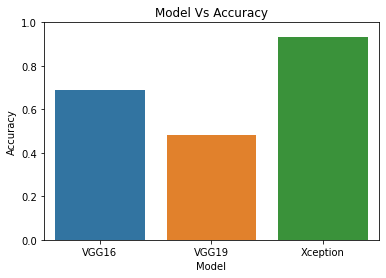

In [ ]:
fig=sns.barplot(x=a,y=b)
fig.set(xlabel='Model', ylabel='Accuracy')
plt.title("Model Vs Accuracy")
plt.ylim(0,1)
plt.show()

###**confusion matrix**

Text(0.5, 15.0, 'Predicted label')

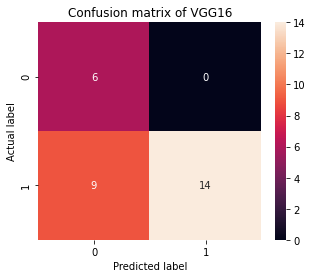

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix of VGG16')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Text(0.5, 15.0, 'Predicted label')

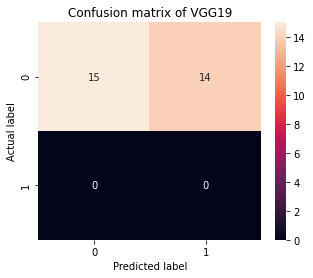

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm2, annot=True, fmt="d")
plt.title('Confusion matrix of VGG19')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

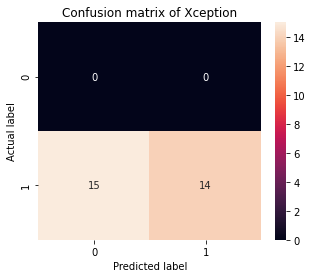

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm3, annot=True, fmt="d")
plt.title('Confusion matrix of Xception')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

###**Accuracy and loss of test and validation data at different Epoch**

## 

In [ ]:
z=[2,5,10,20,40,60,80,100]
accura=[]
los=[]
accura1=[]
los1=[]
for epoch in (z):
  covid21= model2.fit_generator(Datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch=len(x_train) / 8,validation_data=(x_valid, y_valid), epochs=epoch,callbacks = [early_stopping])
  y_pred21 = model2.predict(x_test, batch_size=8)
  y_pred21 = np.argmax(y_pred21, axis=1)
  y_true21 = np.argmax(y_test, axis=1)
  predicted_metrics21 = model2.evaluate(x_test, y_test, batch_size=8, verbose=0)
  predicted_metrics211 = model2.evaluate(x_valid, y_valid, batch_size=8, verbose=0)
  loss21=predicted_metrics21[0]
  acc21=predicted_metrics21[1]
  loss211=predicted_metrics211[0]
  acc211=predicted_metrics211[1]
  los.append(loss21)
  accura.append(acc21)

  los1.append(loss211)
  accura1.append(acc211)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
12/11 [================================] - 6s 498ms/step - loss: 0.2736 - accuracy: 0.8764 - val_loss: 0.5105 - val_accuracy: 0.6087
Epoch 2/2
12/11 [================================] - 6s 501ms/step - loss: 0.3442 - accuracy: 0.8315 - val_loss: 0.5137 - val_accuracy: 0.6087
Epoch 1/5
12/11 [================================] - 6s 513ms/step - loss: 0.3753 - accuracy: 0.8539 - val_loss: 0.4370 - val_accuracy: 0.6522
Epoch 2/5
12/11 [================================] - 6s 515ms/step - loss: 0.2620 - accuracy: 0.8989 - val_loss: 0.4504 - val_accuracy: 0.6087
Epoch 3/5
12/11 [================================] - 6s 522ms/step - loss: 0.2700 - accuracy: 0.8876 - val_loss: 0.2854 - val_accuracy: 0.8261
Epoch 4/5
12/11 [================================] - 6s 512ms/step - loss: 0.2089 - accuracy: 0.9213 - val_loss: 0.2139 - val_accuracy: 0.9130
Epoch 5/5
12/11 [================================] - 6s 499ms/step - loss: 0.3956 - accuracy: 0.8315 - val_loss: 0.1972 - val_accuracy: 0.9130

##**Accuracy Vs Epoch**

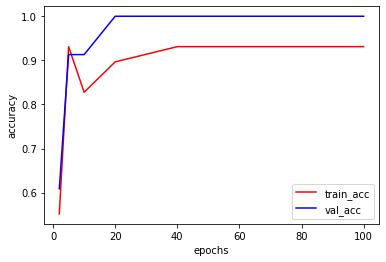

In [ ]:
a1,=plt.plot(z,accura,color='r')
a2,=plt.plot(z,accura1,color='b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend([a1,a2],['train_acc','val_acc'])
plt.show()

##**Loss Vs Epoch**

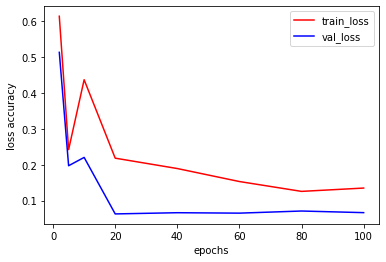

In [ ]:
a1,=plt.plot(z,los,color='r')
a2,=plt.plot(z,los1,color='b')
plt.xlabel('epochs')
plt.ylabel('loss accuracy')
plt.legend([a1,a2],['train_loss','val_loss'])
plt.show()



##**Time of prediction**

In [ ]:
time_=[time1,time2,time3]
time_

[1.0707570000000715, 1.3029800000000478, 0.8208839999999782]

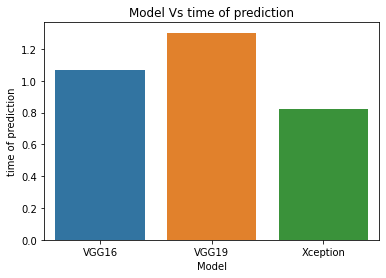

In [ ]:
fig=sns.barplot(x=a,y=time_)
fig.set(xlabel='Model', ylabel='time of prediction')
plt.title("Model Vs time of prediction")
plt.show()

In [ ]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG19(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable (Don't train existing weights)
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    

    #x = baseModel.output
    #x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    #x = tf.keras.layers.Dropout(0.25)(x)

    #x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    #x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    #x = tf.keras.layers.Dropout(0.25)(x)
    

    #x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    #x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    #x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    #x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    #x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    #x = tf.keras.layers.Dropout(0.25)(x)
    x = Flatten()(baseModel.output)

    #x = Flatten()(baseModel.output)
    x = Dense(256, activation='relu')(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(2, activation='softmax')(x)
  
    
    covid_model = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(lr=0.001)
    covid_model.compile(optimizer=adagrad, loss='binary_crossentropy',metrics=["accuracy"])
    return covid_model